# Convolutional Neural Networks

## Preliminaries

In this practical session you will implement and train several Convolutional Neural Networks (CNNs) using the Keras framework with a Tensorflow backend. If you are not already familiar with Keras, you can go over the [following tutorial](https://github.com/tueimage/essential-skills/blob/master/keras.md). More detailed information on the different functionalities can be found in the [Keras library documentation](https://keras.io/). 

Note that for this set of exercise CPU-only Tensorflow, which you should already have installed, is sufficient (i.e. GPU-support is not required but it will make your experiments run faster). 

You are also required to use the `gryds` package for data augmentation that you can install directly from git: `pip install git+https://github.com/tueimage/gryds/`.

You also have to install the Keras deep learning framework (if you have not done so already) by running `conda install keras`. Note that there are two implementations of Keras, one from https://keras.io/ and another one that ships with Tensorflow. Here we use the former. 

## MNIST
We will first train a simple CNN to classify handwritten digits using the MNIST dataset. This dataset is often referred to as the "Hello world!" example of deep learning because it can be used to quickly illustrate a small neural network in action (and obtain a decent classification accuracy in the process). More information on it can be found [here](http://yann.lecun.com/exdb/mnist/).

First, let's load the dataset and visualize some images.

Using TensorFlow backend.


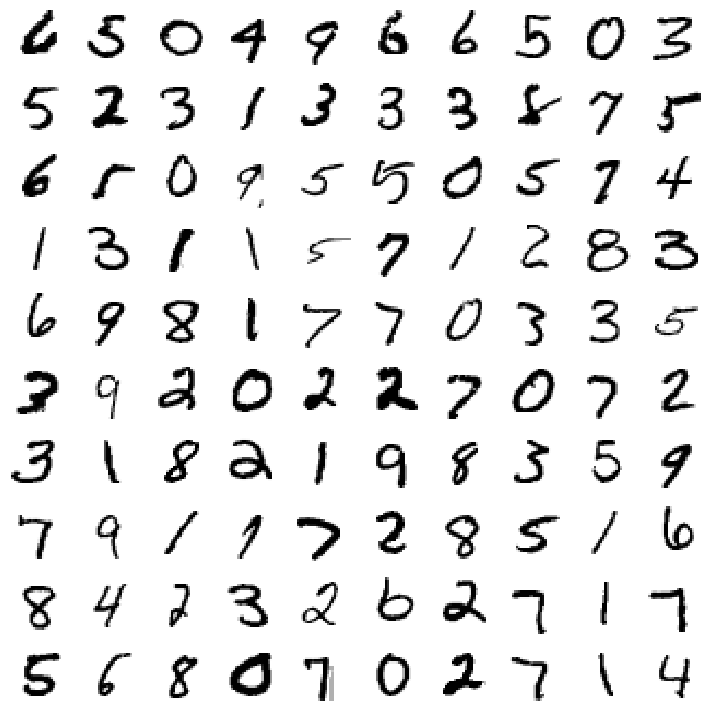

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist
from keras.utils import to_categorical

# load the MNIST the dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# scale the image intensities to the 0-1 range
x_train = (x_train / 255.0).astype(np.float32)
x_test = (x_test / 255.0).astype(np.float32)

# convert the data to channel-last
x_train = np.expand_dims(x_train, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)

# convert the labels to one-hot encoded
y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

def plot_images(images, dim=(10, 10), figsize=(10, 10), title=''):
    
    plt.figure(figsize=figsize)
    
    for i in range(images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(images[i], interpolation='nearest', cmap='gray_r')
        plt.axis('off')
    
    plt.tight_layout()
    plt.suptitle(title)
    plt.show()
    
plot_images(x_train[np.random.randint(0, x_train.shape[0], size=100)].reshape(100, 28, 28))

The MNIST classification task is quite simple: given an image, predict the digit that it contains. Thus, this is a 10-class classification problem.

Let's define a simple network for the handwritten digit classification.

In [2]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense

model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               1179776   
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)              

Compile and train the network (note that this could take a while).

In [3]:
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam

model.compile(loss=categorical_crossentropy, optimizer=Adam(), metrics=['accuracy'])

model.fit(x_train, y_train,
          batch_size=128,
          epochs=12,
          verbose=1,
          validation_data=(x_test, y_test))

score = model.evaluate(x_test, y_test, verbose=0)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 60000 samples, validate on 10000 samples
Epoch 1/12
60000/60000 [==============================] - 17s 285us/step - loss: 0.2459 - accuracy: 0.9249 - val_loss: 0.0530 - val_accuracy: 0.9833
Epoch 2/12
60000/60000 [==============================] - 15s 242us/step - loss: 0.0861 - accuracy: 0.9750 - val_loss: 0.0343 - val_accuracy: 0.9884
Epoch 3/12
60000/60000 [==============================] - 14s 238us/step - loss: 0.0660 - accuracy: 0.9802 - val_loss: 0.0307 - val_accuracy: 0.9898
Epoch 4/12
60000/60000 [==============================] - 14s 238us/step - loss: 0.0546 - accuracy: 0.9833 - val_loss: 0.0310 - val_accuracy: 0.9890
Epoch 5/12
60000/60000 [==============================] - 14s 240us/step - loss: 0.0471 - accuracy: 0.9854 - val_loss: 0.0330 - val_accuracy: 0.9881
Epoch 6/12
60000/60000 [==============================] - 14s 238us/step - loss: 0.0410 - accuracy: 0.9868 - val_loss: 0.0289 - val_accuracy: 0.9901
Epoch 7/12
60000/60000 [==============================] 

Now that the model is trained, we can evaluate its performance on the independent test dataset.

In [4]:
score = model.evaluate(x_test, y_test, verbose=0)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.027273060871312635
Test accuracy: 0.9919000267982483


## U-Net
The U-Net convolutional neural network architecture was first developed for biomedical image segmentation and is to this day one of the most widely used methods for image segmentation. The details of the architecture can be found in the [original paper](https://arxiv.org/abs/1505.04597). In this practical we will build and train a U-Net network that is able to segment blood vessels in retinal images. 

### Loading and visualizing the data
The data for this task is taken from the [DRIVE](https://www.isi.uu.nl/Research/Databases/DRIVE/index.php) database. It consists of photographs of the retina, where the goal is to segment the blood vessels within. The dataset has a total of 40 photographs, divided in 20 images for training and 20 for testing. 

Let's load the training set and visualize an image with the corresponding blood vessel segmentation. For training we will divide the data in a training and a validation set to monitor the model during training.

(20, 584, 565, 3)


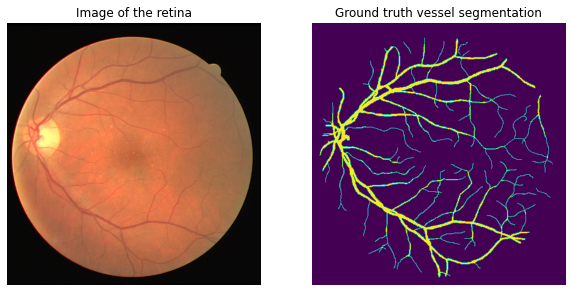

(16, 584, 565, 3)
(16, 584, 565, 1)
(16, 584, 565, 1)
(4, 584, 565, 3)
(4, 584, 565, 1)
(4, 584, 565, 1)


In [5]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from glob import glob
import sys
import os
sys.path.append('code/') 
from unet_utils_new import load_data

# location of the DRIVE dataset
data_folder = os.path.join(os.getcwd(), 'data', 'DRIVE')
search_folder = os.path.join(data_folder, 'training', 'images')
train_paths = glob(search_folder + '\*.tif')
images, masks, segmentations = load_data(train_paths)

# print the shape of image dataset
print(images.shape)

plt.figure(figsize=(10, 8))

plt.subplot(1, 2, 1)
plt.title("Image of the retina")
plt.axis('off')
plt.imshow(images[0])

plt.subplot(1, 2, 2)
plt.title("Ground truth vessel segmentation")
plt.axis('off')
plt.imshow(segmentations[0][:, :, 0])

plt.show()

# divide in training and validation
train_images, val_images, train_masks, val_masks, train_segmentations, val_segmentations = train_test_split(
    images, masks, segmentations, test_size=0.2, random_state=7)

# print the shape of the training and valudation datasets
print(train_images.shape)
print(train_masks.shape)
print(train_segmentations.shape)
print(val_images.shape)
print(val_masks.shape)
print(val_segmentations.shape)

### Training a U-Net model

You are already provided with implementation of the U-Net architecture in `unet_model.py`. This is a modular implementation and can be used to generate U-Net architectures with a variety of hyperparameters such as depth and number of feature maps. Before using the model, examine the code and documentation and make sure that you understand all the details.

We will train a U-Net model using smaller patches extracted from the training images. Training the images on smaller patches requires less computation power and results in a more varied training dataset (it has the effect of data augmentation by image translation). Because a U-Net is a fully convolutional network it can be evaluated on inputs of different size (the output size will change according to the input size). Thus, although the model will be trained on smaller patches it can still be used to segment larger images with one pass through the model. 


(16, 32, 32, 3)


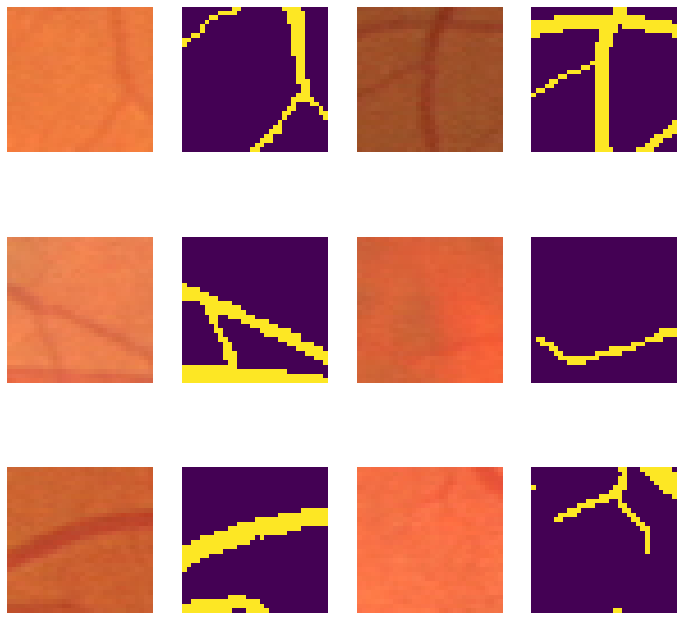

In [6]:
from unet_utils import extract_patches, preprocessing

# work with 32x32 patches
patch_size = (32, 32)

# 200 patches per image
patches_per_im = 200

# visualize a couple of patches as a visual check
patches, patches_segmentations = extract_patches(train_images, train_segmentations, patch_size, patches_per_im=1, seed=7)

print(patches.shape)

fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(12, 12))

for i in range(0, 3):
    axes[i, 0].axis('off')
    axes[i, 0].imshow(patches[i])
    axes[i, 1].axis('off')
    axes[i, 1].imshow(patches_segmentations[i][:, :, 0])
    axes[i, 2].axis('off')
    axes[i, 2].imshow(patches[i+5])
    axes[i, 3].axis('off')
    axes[i, 3].imshow(patches_segmentations[i+5][:, :, 0])

plt.show()

In [7]:
# pad the validation data to fit the U-Net model
# images of shape (584, 565) shape result in concatenation error due to the odd number of columns

print("Old shape:", val_images.shape)

val_images, val_masks, val_segmentations = preprocessing(
    val_images, 
    val_masks, 
    val_segmentations, 
    desired_shape=(584, 584))
    
print("New shape:", val_images.shape)

Old shape: (4, 584, 565, 3)
New shape: (4, 584, 584, 3)


In [8]:
import os
from unet_model import unet
from unet_utils import datagenerator
from keras.models import load_model
from keras.optimizers import Adam, SGD
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# use a single training image, to better demonstrate the effects of data augmentation
X_train_i, y_train_i = np.expand_dims(train_images[0], axis=0), np.expand_dims(train_segmentations[0], axis=0)

print(X_train_i.shape)
print(y_train_i.shape)

# hyperparameters
depth = 3
channels = 32
use_batchnorm = True
batch_size = 64
epochs = 250
steps_per_epoch = int(np.ceil((patches_per_im * len(train_images)) / batch_size))

# work with 32x32 patches
patch_size = (32, 32)
# 200 patches per image
patches_per_im = 200

# initialize model
model = unet(input_shape=(None, None, 3), depth=depth, channels=channels, batchnorm=use_batchnorm)

# print a summary of the model
# model.summary(line_length=120)

# compile the model
model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])

# stop the training if the validation loss does not increase for 15 consecutive epochs
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

(1, 584, 565, 3)
(1, 584, 565, 1)


In [9]:
# train the model with the data generator, and save the training history
history = model.fit_generator(datagenerator(X_train_i, y_train_i, patch_size, patches_per_im, batch_size),
                              validation_data=(val_images, val_segmentations),
                              steps_per_epoch=steps_per_epoch, epochs=epochs, verbose=2,
                              callbacks=[early_stopping])

Epoch 1/250
 - 20s - loss: 0.5225 - accuracy: 0.8174 - val_loss: 0.3972 - val_accuracy: 0.9211
Epoch 2/250
 - 9s - loss: 0.3281 - accuracy: 0.9464 - val_loss: 0.5304 - val_accuracy: 0.7312
Epoch 3/250
 - 9s - loss: 0.2175 - accuracy: 0.9572 - val_loss: 0.2942 - val_accuracy: 0.9211
Epoch 4/250
 - 9s - loss: 0.2034 - accuracy: 0.9556 - val_loss: 0.3167 - val_accuracy: 0.8831
Epoch 5/250
 - 9s - loss: 0.2057 - accuracy: 0.9498 - val_loss: 1.2640 - val_accuracy: 0.5054
Epoch 6/250
 - 9s - loss: 0.1824 - accuracy: 0.9528 - val_loss: 0.2915 - val_accuracy: 0.9218
Epoch 7/250
 - 9s - loss: 0.1447 - accuracy: 0.9581 - val_loss: 0.2769 - val_accuracy: 0.9216
Epoch 8/250
 - 9s - loss: 0.1381 - accuracy: 0.9592 - val_loss: 0.4260 - val_accuracy: 0.9211
Epoch 9/250
 - 9s - loss: 0.1166 - accuracy: 0.9631 - val_loss: 0.4024 - val_accuracy: 0.9221
Epoch 10/250
 - 9s - loss: 0.1287 - accuracy: 0.9608 - val_loss: 0.2359 - val_accuracy: 0.9411
Epoch 11/250
 - 9s - loss: 0.1258 - accuracy: 0.9610 - val

### Visualizing the segmentation results

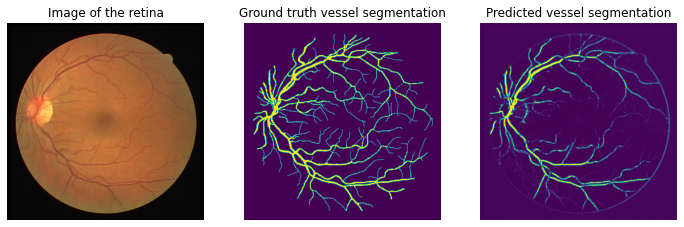

In [10]:
# run the model on one test image and show the results
from unet_utils_new import preprocessing
from unet_utils_new import load_data

# test data paths
search_folder_test = os.path.join(data_folder, 'test', 'images')
impaths_test = glob(search_folder_test + '\*.tif')

# load data
test_images, test_masks, test_segmentations = load_data(impaths_test, test=True)


# pad the data to fit the U-Net model
test_images, test_masks, test_segmentations = preprocessing(test_images, test_masks, test_segmentations, 
                                                            desired_shape=(584, 584))

# use a single image to evaluate
X_test_i, y_test_i = np.expand_dims(test_images[0], axis=0), np.expand_dims(test_masks[0], axis=0)

# predict test samples
test_prediction = model.predict(X_test_i, batch_size=4)

# visualize the test result
plt.figure(figsize=(12, 10))

plt.subplot(1, 3, 1)
plt.title("Image of the retina")
plt.axis('off')
plt.imshow(test_images[0])

plt.subplot(1, 3, 2)
plt.title("Ground truth vessel segmentation")
plt.axis('off')
plt.imshow(test_segmentations[0][:, :, 0])

plt.subplot(1, 3, 3)
plt.title("Predicted vessel segmentation")
plt.axis('off')
plt.imshow(test_prediction[0, :, :, 0])

plt.show()

In [11]:
def dice(pred, true, k = 1):
    intersection = np.sum(pred[true==k]) * 2.0
    dice = intersection / (np.sum(pred) + np.sum(true))
    return dice

In [42]:
#Calculate the dice:
dice_model1 = dice(test_prediction, y_test_i)
print("Dice for model 1 - no augmentation: {}".format(np.round(dice_model1,4)))

Dice for model 1 - no augmentation: 0.1423


# Exercises

## Number of parameters

The first convolutional layer in the MNIST example has 320 parameters. The first fully connected layer has 1179,776 parameters. What do these parameters correspond to? 

<font color='#770a0a'>What is the general expression for the number of parameters of 1) a convolutional layer and 2) a fully-connected layer?</font>

**The number of parameters are the learnable elements for a filter, in general they are the weights that are learnt during training.**

**Convolutional layer: ((kernel_size) x stride + 1) x nr_of_filters)**

**Fully-connected layer: if kernel_size = n, m then the parameters can be calculated with (n+1) x m**

## Fully-convolutional MNIST model

Modify the model in the MNIST example in such a way that it only contains convolutional layers while keeping the same number of parameters. If you do the modification correctly, the two models will have the same behaviour (i.e. they will represent the same model, only with different implementation). Show this experimentally. 

In [14]:
#Fully-convolutional mnist model
#1,199,882 parameters needed

model2 = Sequential()
model2.add(Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model2.add(Conv2D(64, (3, 3), activation='relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Dropout(0.25))
# model2.add(Flatten())
# model2.add(Dense(128, activation='relu'))
model2.add(Conv2D(128, (12, 12), activation='relu'))
model2.add(Dropout(0.5))
# model2.add(Flatten())
# model2.add(Dense(10, activation='softmax')) #1290 
model2.add(Conv2D(10, (1, 1), activation='softmax'))
model2.add(Flatten()) #We need a flatten layer for the final output

model2.summary()


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_21 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 12, 12, 64)        0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 1, 1, 128)         1179776   
_________________________________________________________________
dropout_4 (Dropout)          (None, 1, 1, 128)         0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 1, 1, 10)         

In [15]:
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam

model2.compile(loss=categorical_crossentropy, optimizer=Adam(), metrics=['accuracy'])

model2.fit(x_train, y_train,
          batch_size=128,
          epochs=12,
          verbose=1,
          validation_data=(x_test, y_test))

score2 = model2.evaluate(x_test, y_test, verbose=0)

print('Test loss:', score2[0])
print('Test accuracy:', score2[1])

Train on 60000 samples, validate on 10000 samples
Epoch 1/12
60000/60000 [==============================] - 22s 367us/step - loss: 0.2480 - accuracy: 0.9239 - val_loss: 0.0575 - val_accuracy: 0.9830
Epoch 2/12
60000/60000 [==============================] - 22s 367us/step - loss: 0.0861 - accuracy: 0.9739 - val_loss: 0.0401 - val_accuracy: 0.9866
Epoch 3/12
60000/60000 [==============================] - 21s 346us/step - loss: 0.0649 - accuracy: 0.9802 - val_loss: 0.0364 - val_accuracy: 0.9879
Epoch 4/12
60000/60000 [==============================] - 21s 346us/step - loss: 0.0511 - accuracy: 0.9841 - val_loss: 0.0326 - val_accuracy: 0.9889
Epoch 5/12
60000/60000 [==============================] - 21s 345us/step - loss: 0.0463 - accuracy: 0.9855 - val_loss: 0.0302 - val_accuracy: 0.9897
Epoch 6/12
60000/60000 [==============================] - 21s 346us/step - loss: 0.0378 - accuracy: 0.9879 - val_loss: 0.0279 - val_accuracy: 0.9908
Epoch 7/12
60000/60000 [==============================] 

**The test loss is a bit higher than with the fully connected layers but the accuracy is approximately the same.**

## U-Net architecture

<font color='#770a0a'> What is the role of the skip connections in the U-Net neural network architecture? Will it be possible to train the exact same architecture with the skip connections omitted? If yes, what would be the expected result? If no, what would be the cause of the error?</font>

**The skip-connections make it possible to recover fine-grained details in the final prediction.**


**If we would omit the skip connections we can train the architecture, but it would not be a 'u-net' anymore, it then looks like a normal convolutional neural network. This causes the fine-grained details to be gone in the final prediction.**


## Data augmentation

<font color='#770a0a'>Why does data augmentation result in less overfitting? Can data augmentation be applied to the test samples? If yes, towards what goal? If no, what is preventing that?</font>

**Data augmentation result in less overfitting, since the model is trained on data that are all a little bit different. This causes the model to learn features more robust.**

**Applying data augmentation to the test samples is possible, but it will not add any value. You don’t train the model with the test dataset, you only use it to evaluate the model. Evaluating the model on the augmented test data set only gives you more evaluation metrics. These metrics might be more robust since there are differences in the test data itself, but this is only useful when the augmented images also make sense in real-life. The image after data augmentation applied should thus still reflect real-life images.**


Implement random brightness augmentation of the image data by adding a random offset to the image intensity before passing them trough the network at training time. Train a model with random brightness augmentation and compare it to the baseline above. 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 584, 565, 3)
(1, 584, 565, 3)
(2, 584, 565, 3)


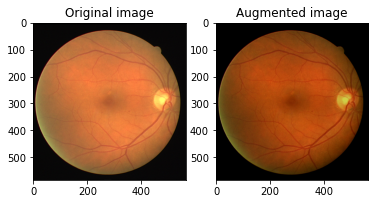

In [16]:
#data augmentation - random brightness
#should be able to do this with tf.image.random_brightness but I cannot load the data at this point.
import tensorflow as tf
max_delta = 0.3
X_train_i_augment = tf.image.random_brightness(X_train_i, max_delta)
print(X_train_i.shape)
print(X_train_i_augment.shape)
X_train_i_new = np.concatenate((X_train_i, X_train_i_augment))
print(X_train_i_new.shape)

plt.subplot(121)
plt.imshow(X_train_i_new[0])
plt.title('Original image')
plt.subplot(122)
plt.imshow(X_train_i_new[1])
plt.title('Augmented image')
plt.show()


In [18]:
#Train the model
# hyperparameters
depth = 3
channels = 32
use_batchnorm = True
batch_size = 64
epochs = 250
steps_per_epoch = int(np.ceil((patches_per_im * len(train_images)) / batch_size))

# work with 32x32 patches
patch_size = (32, 32)
# 200 patches per image
patches_per_im = 200

# initialize model
model3 = unet(input_shape=(None, None, 3), depth=depth, channels=channels, batchnorm=use_batchnorm)

# print a summary of the model
# model.summary(line_length=120)

# compile the model
model3.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])

# stop the training if the validation loss does not increase for 15 consecutive epochs
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

# train the model with the data generator, and save the training history
history3 = model3.fit_generator(datagenerator(X_train_i_new, y_train_i, patch_size, patches_per_im, batch_size),
                              validation_data=(val_images, val_segmentations),
                              steps_per_epoch=steps_per_epoch, epochs=epochs, verbose=2,
                              callbacks=[early_stopping])

Epoch 1/250
 - 14s - loss: 0.6289 - accuracy: 0.7304 - val_loss: 0.5132 - val_accuracy: 0.9211
Epoch 2/250
 - 10s - loss: 0.4143 - accuracy: 0.9565 - val_loss: 0.3548 - val_accuracy: 0.9211
Epoch 3/250
 - 10s - loss: 0.2867 - accuracy: 0.9677 - val_loss: 0.2684 - val_accuracy: 0.9216
Epoch 4/250
 - 10s - loss: 0.1886 - accuracy: 0.9767 - val_loss: 0.2798 - val_accuracy: 0.9211
Epoch 5/250
 - 10s - loss: 0.1303 - accuracy: 0.9803 - val_loss: 0.2730 - val_accuracy: 0.9204
Epoch 6/250
 - 10s - loss: 0.1022 - accuracy: 0.9802 - val_loss: 0.2392 - val_accuracy: 0.9253
Epoch 7/250
 - 10s - loss: 0.0856 - accuracy: 0.9804 - val_loss: 0.2586 - val_accuracy: 0.9270
Epoch 8/250
 - 10s - loss: 0.0743 - accuracy: 0.9810 - val_loss: 0.2730 - val_accuracy: 0.8948
Epoch 9/250
 - 10s - loss: 0.0663 - accuracy: 0.9809 - val_loss: 0.2496 - val_accuracy: 0.9197
Epoch 10/250
 - 10s - loss: 0.0623 - accuracy: 0.9808 - val_loss: 0.2349 - val_accuracy: 0.9372
Epoch 11/250
 - 10s - loss: 0.0576 - accuracy: 0.

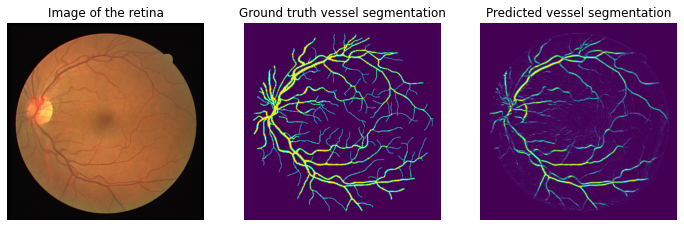

In [19]:
# predict test samples
test_prediction3 = model3.predict(X_test_i, batch_size=4)

# visualize the test result
plt.figure(figsize=(12, 10))

plt.subplot(1, 3, 1)
plt.title("Image of the retina")
plt.axis('off')
plt.imshow(test_images[0])

plt.subplot(1, 3, 2)
plt.title("Ground truth vessel segmentation")
plt.axis('off')
plt.imshow(test_segmentations[0][:, :, 0])

plt.subplot(1, 3, 3)
plt.title("Predicted vessel segmentation")
plt.axis('off')
plt.imshow(test_prediction3[0, :, :, 0])

plt.show()

In [41]:
#Calculate the dice:
dice_model3 = dice(test_prediction3, y_test_i)
print("Dice for model data augmentation random brightness: {}".format(np.round(dice_model3,4)))

Dice for model data augmentation random brightness: 0.1482


<font color='red'> **Comparison: in order to compare the models we have implemented the dice score. The dice score represents the similarity between two masks. When no data augmentation was used, the dice score was 0.1423. When we use random brightness as data augmentation, the dice score increases to 0.1482. This means the use of random brightness enables the model to learn more generic features.** </font>

Implement data augmentation procedure that in addition to brightness augmentation also performs b-spline geometric augmentation using the [`gryds`](https://github.com/tueimage/gryds) package (you can look at the documentation of the package for an example on how to do that). Compare the new model with the baseline and the model that only performs brightness augmentation.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(3, 584, 565, 3)


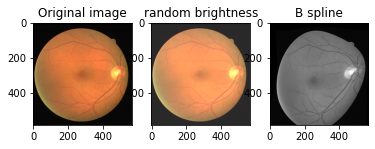

In [36]:
import numpy as np
import gryds

#data augmentation - random brightness and b-spline geometric augmentation
X_train_i_augment_rb = tf.image.random_brightness(X_train_i, max_delta)


# Define a random 3x3 B-spline grid for a 2D image:
random_grid = np.random.rand(2, 3, 3)
random_grid -= 0.5
random_grid /= 5

image = X_train_i[0][:,:,1] #Gryd can only work with 2D images and not with rgb images for some reason

# Define a B-spline transformation object
bspline = gryds.BSplineTransformation(random_grid)
# Define an interpolator object for the image:
interpolator = gryds.Interpolator(image)
# Transform the image using the B-spline transformation
augment_Bs_gray = interpolator.transform(bspline)
augment_Bs_gray_1 = np.expand_dims(augment_Bs_gray, axis=2)
augment_Bs_color = tf.image.grayscale_to_rgb(tf.convert_to_tensor(augment_Bs_gray_1))
X_train_i_augment_Bs = np.expand_dims(augment_Bs_color, axis=0)

#Add the augmented images to a new train list
X_train_i_new2 = np.concatenate((X_train_i, X_train_i_augment_rb, X_train_i_augment_Bs))
print(X_train_i_new2.shape)

plt.subplot(131)
plt.imshow(X_train_i_new2[0])
plt.title('Original image')
plt.subplot(132)
plt.imshow(X_train_i_new2[1])
plt.title('random brightness')
plt.subplot(133)
plt.imshow(X_train_i_new2[2])
plt.title('B spline')
plt.show()


In [38]:
# initialize model
model4 = unet(input_shape=(None, None, 3), depth=depth, channels=channels, batchnorm=use_batchnorm) #grayscale

# print a summary of the model
# model.summary(line_length=120)

# compile the model
model4.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])

# stop the training if the validation loss does not increase for 15 consecutive epochs
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

# train the model with the data generator, and save the training history
history4 = model4.fit_generator(datagenerator(X_train_i_new2, y_train_i, patch_size, patches_per_im, batch_size),
                              validation_data=(val_images, val_segmentations),
                              steps_per_epoch=steps_per_epoch, epochs=epochs, verbose=2,
                              callbacks=[early_stopping])

Epoch 1/250
 - 21s - loss: 0.6322 - accuracy: 0.7369 - val_loss: 0.5499 - val_accuracy: 0.9211
Epoch 2/250
 - 11s - loss: 0.4434 - accuracy: 0.9511 - val_loss: 0.3541 - val_accuracy: 0.9211
Epoch 3/250
 - 12s - loss: 0.3003 - accuracy: 0.9727 - val_loss: 0.3322 - val_accuracy: 0.9359
Epoch 4/250
 - 11s - loss: 0.1927 - accuracy: 0.9803 - val_loss: 0.5699 - val_accuracy: 0.7299
Epoch 5/250
 - 11s - loss: 0.1278 - accuracy: 0.9836 - val_loss: 0.3248 - val_accuracy: 0.8951
Epoch 6/250
 - 11s - loss: 0.0967 - accuracy: 0.9846 - val_loss: 0.2490 - val_accuracy: 0.9189
Epoch 7/250
 - 11s - loss: 0.0768 - accuracy: 0.9855 - val_loss: 0.2918 - val_accuracy: 0.8849
Epoch 8/250
 - 11s - loss: 0.0679 - accuracy: 0.9851 - val_loss: 1.4220 - val_accuracy: 0.6198
Epoch 9/250
 - 11s - loss: 0.0569 - accuracy: 0.9866 - val_loss: 10.3439 - val_accuracy: 0.3969
Epoch 10/250
 - 11s - loss: 0.0575 - accuracy: 0.9848 - val_loss: 8.9358 - val_accuracy: 0.4141
Epoch 11/250
 - 12s - loss: 0.0478 - accuracy: 0

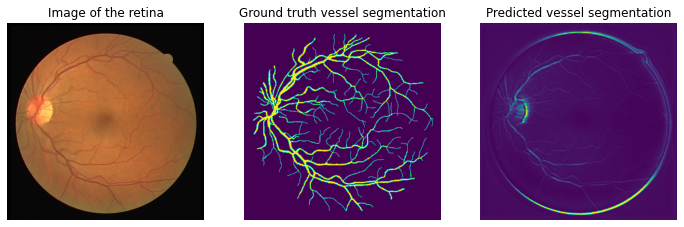

In [39]:
# predict test samples
test_prediction4 = model4.predict(X_test_i, batch_size=4)

# visualize the test result
plt.figure(figsize=(12, 10))

plt.subplot(1, 3, 1)
plt.title("Image of the retina")
plt.axis('off')
plt.imshow(test_images[0])

plt.subplot(1, 3, 2)
plt.title("Ground truth vessel segmentation")
plt.axis('off')
plt.imshow(test_segmentations[0][:, :, 0])

plt.subplot(1, 3, 3)
plt.title("Predicted vessel segmentation")
plt.axis('off')
plt.imshow(test_prediction4[0, :, :, 0])

plt.show()

In [40]:
#Calculate the dice:
dice_model4 = dice(test_prediction4, y_test_i)
print("Dice for model data augmentation random brightness and B-spline: {}".format(np.round(dice_model4,4)))

Dice for model data augmentation random brightness and B-spline: 0.0975


<font color='red'> **Comparison: When no data augmentation was used, the dice score was 0.1423. When we use random brightness coupled with the B-spline as data augmentation, the dice score decreases to 0.0975. Only using random brightness did increase the dice score, thus it seems the B-spline throws off the model. This can be due to the fact that the image added after B spline does not have the nice round edges for the retina, which could cause the model to think it has to learn where the edge is as well. This is also seen in the predicted vessel segmentation, the model predicted the edges of the retina and not a lot of vessels.** </font>